In [1]:
import matplotlib.pyplot as plt
import gc

# Astropy imports
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Image visualization routines.
import lsst.afw.display as afwDisplay
# The Butler provides programmatic access to LSST data products.
from lsst.daf.butler import Butler

# Import the Rubin TAP service utilities
from lsst.rsp import get_tap_service

# Geometry package
import lsst.geom as geom
# Object for multi-band exposures
from lsst.afw.image import MultibandExposure

afwDisplay.setDefaultBackend('matplotlib')
plt.style.use('tableau-colorblind10')
%matplotlib inline

In [2]:
# params = {'axes.labelsize': 28,
#           'font.size': 24,
#           'legend.fontsize': 14,
#           'xtick.major.width': 3,
#           'xtick.minor.width': 2,
#           'xtick.major.size': 12,
#           'xtick.minor.size': 6,
#           'xtick.direction': 'in',
#           'xtick.top': True,
#           'lines.linewidth': 3,
#           'axes.linewidth': 3,
#           'axes.labelweight': 3,
#           'axes.titleweight': 3,
#           'ytick.major.width': 3,
#           'ytick.minor.width': 2,
#           'ytick.major.size': 12,
#           'ytick.minor.size': 6,
#           'ytick.direction': 'in',
#           'ytick.right': True,
#           'figure.figsize': [8, 8],
#           'figure.facecolor': 'White'
#           }

# plt.rcParams.update(params)

In [3]:
def remove_figure(fig):
    """
    Remove a figure to reduce memory footprint.

    Parameters
    ----------
    fig: matplotlib.figure.Figure
        Figure to be removed.

    Returns
    -------
    None
    """
    # get the axes and clear their images
    for ax in fig.get_axes():
        for im in ax.get_images():
            im.remove()
    fig.clf()       # clear the figure
    plt.close(fig)  # close the figure
    gc.collect()    # call the garbage collector

In [4]:
def cutout_coadd(butler, ra, dec, band='r', datasetType='deepCoadd',
                 skymap=None, cutoutSideLength=51, **kwargs):
    """
    Produce a cutout from a coadd at the given ra, dec position.

    Adapted from DC2 tutorial notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    band: string
        Filter of the image to load
    datasetType: string ['deepCoadd']
        Which type of coadd to load.  Doesn't support 'calexp'
    skymap: lsst.afw.skyMap.SkyMap [optional]
        Pass in to avoid the Butler read.  Useful if you have lots of them.
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

    if skymap is None:
        skymap = butler.get("skyMap")

    # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = geom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    patch = tractInfo.getSequentialPatchIndex(patchInfo)

    coaddId = {'tract': tractInfo.getId(), 'patch': patch, 'band': band}
    parameters = {'bbox': bbox}

    cutout_image = butler.get(datasetType, parameters=parameters,
                              dataId=coaddId)

    return cutout_image

In [5]:
butler = Butler('dp02', collections='2.2i/runs/DP0.2')

## cutout_coadd

In [6]:
coadd_dataId = {'tract': 4431, 'patch': 17, 'band': 'i'}
coadd = butler.get('deepCoadd', **coadd_dataId)

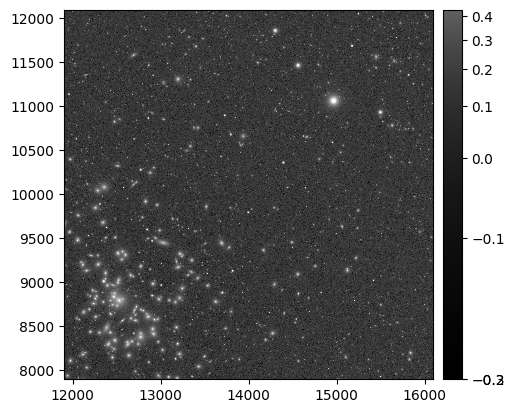

In [7]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(coadd.image)
plt.show()
remove_figure(fig)

In [8]:
wcs = coadd.getWcs()
radec = wcs.pixelToSky(12500, 8500)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

55.7506834813934 -32.28892993702273


In [9]:
cutout_coadd = cutout_coadd(butler, ra, dec, 
                            band='i', datasetType='deepCoadd', 
                            cutoutSideLength=501)

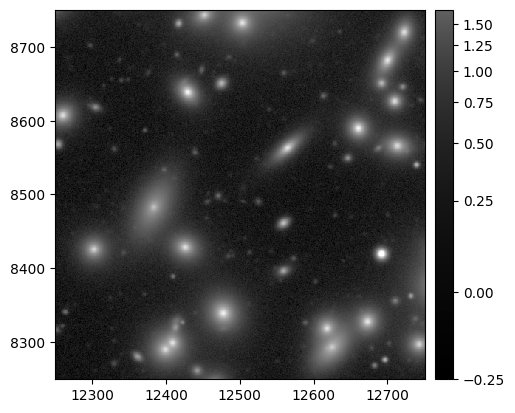

In [10]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_coadd.image)
plt.show()
remove_figure(fig)

In [11]:
del cutout_coadd

## cutout_calexp

In [15]:
calexp_dataId = {'visit': 192350, 'detector': 175}
calexp = butler.get('calexp', **calexp_dataId)

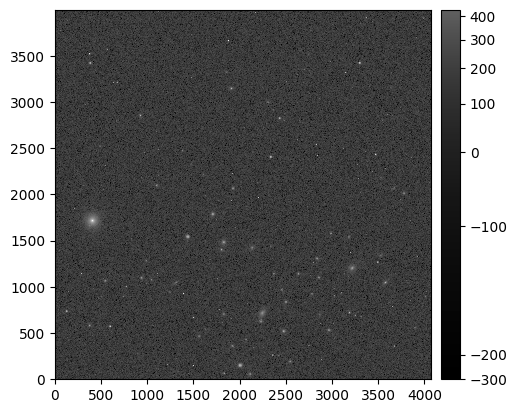

In [16]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(calexp.image)
plt.show()
remove_figure(fig)

In [18]:
wcs = calexp.getWcs()
radec = wcs.pixelToSky(2250, 700)
ra, dec = radec.getRa().asDegrees(), radec.getDec().asDegrees()
print(ra, dec)

53.09004683168595 -33.97759584632161


In [19]:
visit = 192350
detector = 175

In [29]:
cutoutSideLength=201

In [30]:
dataId = {'visit': visit, 'detector': detector}

In [31]:
radec = geom.SpherePoint(ra, dec, geom.degrees)
cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)

In [32]:
calexp_wcs = butler.get('calexp.wcs', **dataId)

In [33]:
xy = geom.PointI(calexp_wcs.skyToPixel(radec))
bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)

In [34]:
parameters = {'bbox': bbox}

In [35]:
cutout_image = butler.get('calexp', parameters=parameters, **dataId)

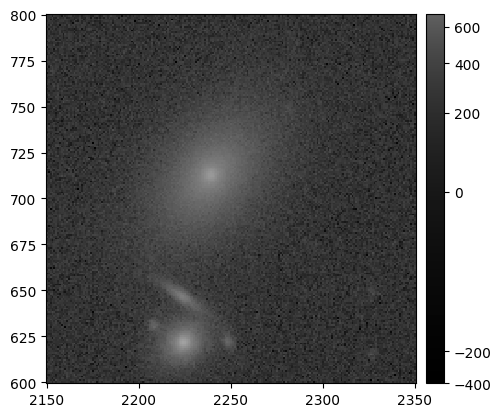

In [36]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_image.image)
plt.show()
remove_figure(fig)

In [37]:
def cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=51, **kwargs):
    
    """
    Produce a cutout from a calexp at the given ra, dec position.

    Adapted from cutout_coadd which was adapted from a DC2 tutorial
    notebook by Michael Wood-Vasey.

    Parameters
    ----------
    butler: lsst.daf.persistence.Butler
        Servant providing access to a data repository
    ra: float
        Right ascension of the center of the cutout, in degrees
    dec: float
        Declination of the center of the cutout, in degrees
    visit: int
        Visit id of the calexp's visit
    detector: int
        Detector for the calexp
    cutoutSideLength: float [optional]
        Size of the cutout region in pixels.

    Returns
    -------
    MaskedImage
    """
    
    dataId = {'visit': visit, 'detector': detector}    
    radec = geom.SpherePoint(ra, dec, geom.degrees)
    cutoutSize = geom.ExtentI(cutoutSideLength, cutoutSideLength)    
    calexp_wcs = butler.get('calexp.wcs', **dataId)
    xy = geom.PointI(calexp_wcs.skyToPixel(radec))
    bbox = geom.BoxI(xy - cutoutSize // 2, cutoutSize)
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, **dataId)

    return cutout_image

In [38]:
cutout_calexp = cutout_calexp(butler, ra, dec, visit, detector, cutoutSideLength=301)

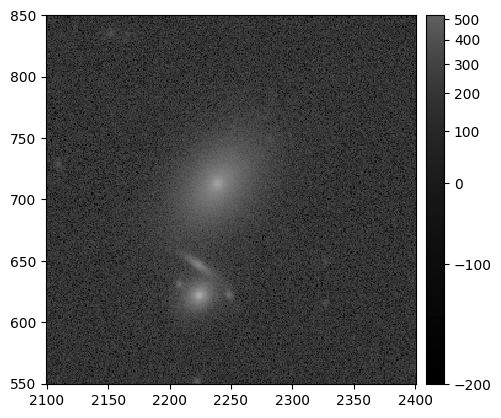

In [39]:
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale('asinh', 'zscale')
display.mtv(cutout_calexp.image)
plt.show()
remove_figure(fig)